In [1]:
import sys
import os
import pandas as pd
import seaborn as sns


In [2]:
sys.path.append('..')

In [3]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN

%load_ext autoreload
%autoreload 2

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [4]:
HOME = os.environ.get('HOME')

# MIMIC-III Dataset Directory
mimic3_dir = f'{HOME}/GP/ehr-data/mimic3-transforms'

# ICE-NODE/M trained on MIMIC-III training partition (70%)
icenode_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20.dynM3_icenode_2lr_M/trial_097/step0045_params.pickle'
icenode_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20.dynM3_icenode_2lr_M/trial_097/config.json'

# RETAIN trained on MIMIC-III training partition (70%)
retain_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_retain_M/trial_171/step0099_params.pickle'
retain_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_retain_M/trial_171/config.json'

# GRU=GRAM/M trained on MIMIC-III training partition (70%)
gru_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_gram_M/trial_649/step0096_params.pickle'
gru_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_gram_M/trial_649/config.json'

# # GRAM=GRAM/G trained on MIMIC-III training partition (70%)
# gram_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_G/frozen_trial_442'

## Patient Interface for each Model

In [5]:
icnode_patient_interface = ICENODE.create_patient_interface(mimic3_dir, 'M3')

2022-02-22 19:56:54.441642: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [6]:
retain_patient_interface = RETAIN.create_patient_interface(mimic3_dir, 'M3')
gram_patient_interface = GRAM.create_patient_interface(mimic3_dir, 'M3')

## Dataset Partitioning

In [7]:
import random

# seed 42 is used in all our experiments in this work.
rng = random.Random(42)
subjects_id = list(icnode_patient_interface.subjects.keys())
rng.shuffle(subjects_id)

# splits = train:val:test = 0.7:.15:.15
splits = int(.7 * len(subjects_id)), int(.85 * len(subjects_id))

train_ids = subjects_id[:splits[0]]
valid_ids = subjects_id[splits[0]:splits[1]]
test_ids = subjects_id[splits[1]:]

## Load Config/Params

In [8]:
from icenode.utils import load_config, load_params

icenode_config = load_config(icenode_m3_config)
icenode_params = load_params(icenode_m3_params)

retain_config = load_config(retain_m3_config)
retain_params = load_params(retain_m3_params)

gru_config = load_config(gru_m3_config)
gru_params = load_params(gru_m3_params)

# gram_config = load_config(f'{gram_m3_dir}/config.json')
# gram_params = load_params(f'{gram_m3_dir}/step0100_params.pickle')

## Load Models

In [9]:
icenode = ICENODE.create_model(icenode_config, icnode_patient_interface, train_ids, None)
icenode_state = icenode.init_with_params(icenode_config, icenode_params)

retain = RETAIN.create_model(retain_config, retain_patient_interface, train_ids, None)
retain_state = retain.init_with_params(retain_config, retain_params)


gru = GRAM.create_model(gru_config, gram_patient_interface, train_ids, None)
gru_state = gru.init_with_params(gru_config, gru_params)


## Per-code performance

In [10]:
from icenode.metrics import codes_auc_pairwise_tests

In [11]:
test_res = {
    'ICENODE': icenode.eval(icenode_state, test_ids)['diag_detectability'],
    'RETAIN': retain.eval(retain_state, test_ids)['diag_detectability'],
    'GRU': gru.eval(gru_state, test_ids)['diag_detectability']
}

In [12]:
tests_raw = codes_auc_pairwise_tests(test_res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [01:03<00:00,  3.81it/s]


## Correlation between AUC and N_POS_CODES

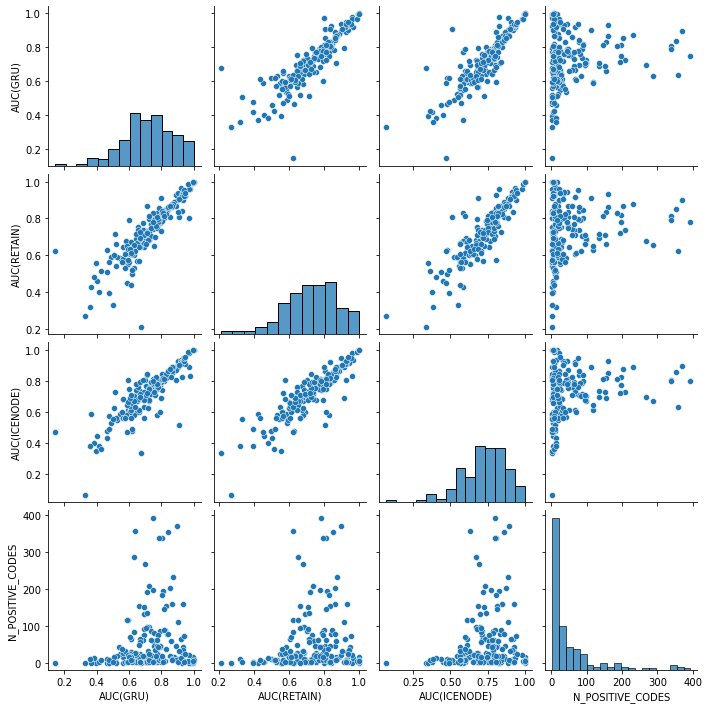

In [13]:
tests_raw_auc_corr = tests_raw[[f'AUC({clf})' for clf in ('GRU', 'RETAIN', 'ICENODE')] + ['N_POSITIVE_CODES']]
sns.pairplot(tests_raw_auc_corr)

In [15]:
flatccs_idx2code = {idx: code for code, idx in icnode_patient_interface.diag_flatccs_idx.items()}
idx2desc = lambda i: icnode_patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
tests_raw['DESC'] = tests_raw['CODE_INDEX'].apply(idx2desc)
tests_raw

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
0,0,4.0,0.489303,0.525622,0.590547,0.869250,0.586623,0.597493,No DX
1,1,17.0,0.564101,0.683883,0.644628,0.115549,0.190191,0.597306,Tuberculosis
2,2,88.0,0.788767,0.785979,0.796071,0.832306,0.487360,0.493986,Immuniz/scrn
3,3,370.0,0.894996,0.893719,0.896929,0.805592,0.677353,0.584369,Acute MI
4,4,18.0,0.692679,0.628938,0.642337,0.259379,0.252416,0.843587,Coron athero
...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.714232,0.720633,0.717521,0.658458,0.779997,0.797749,2ndary malig
179,179,146.0,0.815041,0.810838,0.811493,0.663989,0.670746,0.953879,Malig neopls
180,180,63.0,0.770714,0.777526,0.808014,0.643226,0.035524,0.120549,Neoplsm unsp
181,181,393.0,0.750262,0.797534,0.781738,0.000016,0.000026,0.061384,Maint chem/r


In [16]:
# remove codes that no classifier has scored above 0.6
at_least_AUC_06 = tests_raw.loc[:,[f'AUC({clf})' for clf in ('GRU', 'RETAIN', 'ICENODE')]].max(axis=1) > 0.6
tests = tests_raw[at_least_AUC_06]
tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
1,1,17.0,0.564101,0.683883,0.644628,0.115549,0.190191,0.597306,Tuberculosis
2,2,88.0,0.788767,0.785979,0.796071,0.832306,0.487360,0.493986,Immuniz/scrn
3,3,370.0,0.894996,0.893719,0.896929,0.805592,0.677353,0.584369,Acute MI
4,4,18.0,0.692679,0.628938,0.642337,0.259379,0.252416,0.843587,Coron athero
5,5,77.0,0.692534,0.710482,0.733488,0.482505,0.069347,0.202038,Chest pain
...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.714232,0.720633,0.717521,0.658458,0.779997,0.797749,2ndary malig
179,179,146.0,0.815041,0.810838,0.811493,0.663989,0.670746,0.953879,Malig neopls
180,180,63.0,0.770714,0.777526,0.808014,0.643226,0.035524,0.120549,Neoplsm unsp
181,181,393.0,0.750262,0.797534,0.781738,0.000016,0.000026,0.061384,Maint chem/r


In [17]:
tests.isnull().sum()

CODE_INDEX                     0
N_POSITIVE_CODES               0
AUC(GRU)                       0
AUC(ICENODE)                   0
AUC(RETAIN)                    0
P0(AUC_GRU==AUC_ICENODE)       0
P0(AUC_GRU==AUC_RETAIN)        1
P0(AUC_ICENODE==AUC_RETAIN)    0
DESC                           0
dtype: int64

In [18]:
# remove the code with null p-value
tests = tests[tests['P0(AUC_GRU==AUC_RETAIN)'].notnull()]

In [19]:
from collections import defaultdict
auc_sets = defaultdict(set)
clfs = ('GRU', 'ICENODE', 'RETAIN')
clfs_pairs = []
for i in range(len(clfs)):
    for j in range(i + 1, len(clfs)):
        clfs_pairs.append((clfs[i], clfs[j]))
clfs_pairs = tuple(clfs_pairs)

In [20]:
# Extract codes that are predicted with equivalent performance with all classifiers.
test_cols = tuple(f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs)

In [21]:
common_perf = tests[(tests[test_cols[0]] > 0.05) & (tests[test_cols[1]] > 0.05) & (tests[test_cols[2]] > 0.05)]
auc_sets[clfs] = set(common_perf.CODE_INDEX)

In [22]:
common_perf

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
1,1,17.0,0.564101,0.683883,0.644628,0.115549,0.190191,0.597306,Tuberculosis
2,2,88.0,0.788767,0.785979,0.796071,0.832306,0.487360,0.493986,Immuniz/scrn
3,3,370.0,0.894996,0.893719,0.896929,0.805592,0.677353,0.584369,Acute MI
4,4,18.0,0.692679,0.628938,0.642337,0.259379,0.252416,0.843587,Coron athero
5,5,77.0,0.692534,0.710482,0.733488,0.482505,0.069347,0.202038,Chest pain
...,...,...,...,...,...,...,...,...,...
168,168,78.0,0.841169,0.861646,0.860062,0.133344,0.110693,0.910440,Kidny/rnl ca
172,172,33.0,0.906483,0.901422,0.902105,0.536586,0.572521,0.927216,Hodgkin-s ds
177,177,8.0,0.611763,0.562313,0.435814,0.543028,0.064814,0.248530,Ot primry ca
178,178,193.0,0.714232,0.720633,0.717521,0.658458,0.779997,0.797749,2ndary malig


In [23]:
competing_tests = tests.drop(index=common_perf.index)

In [24]:
for index, row in competing_tests.iterrows():
    max_auc_clf = max(clfs, key=lambda clf: row[f'AUC({clf})'])
    relevant_tests = {(clf1, clf2): f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs if max_auc_clf in (clf1, clf2)}
    
    significant_max = True
    for (clf1, clf2), test_col in relevant_tests.items():
        # If max_auc_clf has maximum AUC, but without insigificant difference with another classifier
        # then consider both outperforming the third classifier.
        if row[test_col] > 0.05:
            significant_max = False
            auc_sets[(clf1, clf2)].add(int(row['CODE_INDEX']))
    
    if significant_max:
        auc_sets[max_auc_clf].add(int(row['CODE_INDEX']))

In [70]:
# Prepare for using Upset plot

best_sets = {}
for clf in clfs:
    best_sets[clf] = auc_sets[clf] | auc_sets[clfs]
    
    for clf1, clf2 in clfs_pairs:
        if clf in (clf1, clf2):
            best_sets[clf].update(auc_sets[(clf1, clf2)])
    

In [71]:
from upsetplot import from_contents, plot, UpSet
import matplotlib.pyplot as plt

In [72]:
upset_contents = from_contents(best_sets)

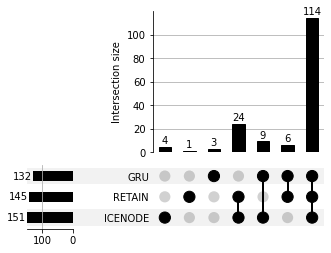

In [73]:
UpSet(upset_contents, subset_size='count', show_counts=True).plot()
plt.show()

In [74]:
icenode_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(best_sets['ICENODE'])]
retain_best_tests =  competing_tests[competing_tests['CODE_INDEX'].isin(best_sets['RETAIN'])]
gru_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(best_sets['GRU'])]

icenode_exc_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets['ICENODE'])]
retain_exc_best_tests =  competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets['RETAIN'])]
gru_exc_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets['GRU'])]

In [66]:
icenode_exc_best_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
47,47,20.0,0.655662,0.759808,0.645096,0.034159,0.821472,0.029197,Gastritis
112,112,85.0,0.632353,0.704966,0.622880,0.007767,0.679989,0.000373,Ot respir ca
126,126,29.0,0.564532,0.680225,0.578501,0.015012,0.719884,0.040162,Ot bone dx
169,169,17.0,0.614148,0.707424,0.611065,0.001978,0.915220,0.000749,Uriny org ca


In [138]:
icenode_best_test_above07 = icenode_best_tests[icenode_best_tests['AUC(ICENODE)'] > 0.7]
icenode_best_test_above07

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
6,6,5.0,0.512749,0.728287,0.715538,0.001789,0.129492,0.864087,Pulm hart dx
10,10,353.0,0.839473,0.858020,0.850782,0.008616,0.068174,0.319353,Cardia arrst
14,14,27.0,0.774100,0.788244,0.752829,0.449434,0.104247,0.028963,Precere occl
19,19,8.0,0.647727,0.720405,0.566434,0.154305,0.248199,0.043366,Aneurysm
28,28,5.0,0.705080,0.767629,0.675199,0.175645,0.728348,0.044105,Influenza
31,31,63.0,0.689184,0.711735,0.738297,0.321528,0.008128,0.210487,Ot up rsp in
35,35,66.0,0.666394,0.732430,0.711414,0.015354,0.107320,0.390132,Stomch cancr
40,40,197.0,0.749537,0.775062,0.777256,0.036540,0.003244,0.844407,Ot uppr resp
45,45,28.0,0.641765,0.739479,0.686326,0.001682,0.183332,0.090425,Gasduo ulcer
46,46,18.0,0.708487,0.835744,0.864839,0.008204,0.039425,0.547001,Colon cancer


In [67]:
retain_exc_best_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
156,156,75.0,0.938601,0.942655,0.955774,0.463446,0.015558,0.040518,Uterus cancr


In [68]:
gru_exc_best_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
21,21,98.0,0.725419,0.671509,0.681769,2.462299e-02,0.019013,0.612399,Ot circul dx
27,27,2.0,0.977656,0.828699,0.957299,1.199828e-03,0.000406,0.002475,Pneumonia
52,52,10.0,0.909910,0.513013,0.806907,2.910674e-09,0.000022,0.000009,Int obstruct


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [35]:
icenode_visit_auc_df = icenode.admissions_auc_scores(icenode_state, test_ids)

In [103]:
icenode_visit_auc_df['N_VISITS'] = icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
icenode_visit_auc_df

,SUBJECT_ID,HADM_ID,HADM_IDX,AUC,N_CODES,TIME,INTERVALS,LOS,R/T,NFE,N_VISITS
0,19842,169734,0,0.976900,7.0,412.5,412.5,3.5,0.0,26.0,5
1,19842,186772,1,0.939872,13.0,433.5,21.0,7.5,0.0,20.0,5
2,19842,180229,2,0.947650,8.0,448.5,15.0,3.5,0.0,20.0,5
3,19842,122439,3,0.944203,12.0,509.5,61.0,7.5,0.0,20.0,5
4,19842,163738,4,0.983078,11.0,552.5,43.0,5.5,0.0,20.0,5
...,...,...,...,...,...,...,...,...,...,...,...
1003,26421,192868,1,0.955274,5.0,278.5,186.0,3.5,0.0,26.0,2
1004,2558,105758,0,0.910348,9.0,59.5,59.5,4.5,0.0,20.0,2
1005,2558,194247,1,0.973860,7.0,70.5,11.0,4.5,0.0,14.0,2
1006,10832,196835,0,0.973860,7.0,647.5,647.5,8.5,0.0,26.0,2


In [104]:
visit_auc_subject = icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_VISITS': 'max', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean'], 'R/T': ['min', 'max', 'mean'] })


In [139]:
best_visit_auc_subjects =  visit_auc_subject[(visit_auc_subject.AUC['mean'] > 0.7) & (visit_auc_subject.N_VISITS['max'] > 1)  & (visit_auc_subject.INTERVALS['mean'] < 120)]
best_visit_auc_subjects

AUC N_VISITS N_CODES                           INTERVALS  \
                mean      max     min   max       mean median        mean   
SUBJECT_ID                                                                  
2558        0.942104        2     7.0   9.0   8.000000    8.0   35.250000   
3365        0.949252        2     8.0   8.0   8.000000    8.0   57.250000   
4268        0.899381        3    12.0  18.0  14.666667   14.0   90.500000   
7752        0.952866        2     9.0  10.0   9.500000    9.5  107.250000   
8551        0.929677        2    10.0  14.0  12.000000   12.0  113.750000   
8734        0.932035        6     7.0  18.0  13.333333   13.0  104.083333   
9923        0.974690        2     7.0   8.0   7.500000    7.5   25.250000   
10088       0.857881        2    14.0  19.0  16.500000   16.5   67.250000   
10634       0.876059        2     8.0  10.0   9.000000    9.0   22.750000   
10642       0.938640        3     6.0   8.0   7.000000    7.0   31.500000   
11861       0.952827       33     3.0  16.0   8.606061    7.0   87.772727   
14749       0.977719        2     5.0   7.0   6.000000    6.0   39.250000   
17794       0.969620        2     5.0   5.0   5.000000    5.0   82.750000   
19842       0.958340        5     7.0  13.0  10.200000   11.0  110.500000   
21892       0.944567        2     6.0  11.0   8.500000    8.5   49.750000   
22297       0.950857        2     8.0  10.0   9.000000    9.0   78.250000   
22578       0.915018        2     8.0  10.0   9.000000    9.0   54.250000   
23706       0.973478        8     6.0  14.0   8.750000    8.0   60.437500   
26709       0.925885        3    12.0  13.0  12.333333   12.0   37.500000   
27468       0.963564        2     7.0   8.0   7.500000    7.5  114.250000   
28182       0.780208        2     1.0   2.0   1.500000    1.5   78.250000   
28902       0.987969        2    10.0  11.0  10.500000   10.5   58.750000   
29581       0.944162        2    12.0  14.0  13.000000   13.0  105.750000   
30243       0.973798        4     3.0   7.0   5.500000    6.0   82.125000   
31170       0.960470        2     8.0   8.0   8.000000    8.0   28.750000   
31312       0.938697        3     6.0   9.0   7.000000    6.0   91.833333   
40911       0.953608        5    12.0  15.0  14.000000   14.0   43.700000   
44265       0.923806        2     9.0  15.0  12.000000   12.0   73.250000   
46287       0.925373        3     7.0  10.0   8.333333    8.0   47.166667   
47775       0.939398        2    13.0  16.0  14.500000   14.5   36.750000   
49037       0.918251        2     9.0  14.0  11.500000   11.5   17.750000   
50772       0.968039        4    12.0  17.0  14.500000   14.5  112.875000   
56187       0.948242        2     5.0  10.0   7.500000    7.5  114.250000   
56502       0.928084        2     6.0  11.0   8.500000    8.5   14.750000   
57330       0.893318        2    16.0  17.0  16.500000   16.5   38.750000   
59841       0.948664        3    10.0  11.0  10.333333   10.0   43.500000   
63177       0.949991        2    15.0  17.0  16.000000   16.0   46.750000   
65824       0.826949        3    13.0  17.0  15.000000   15.0  118.500000   
66256       0.948508        2    13.0  14.0  13.500000   13.5   13.250000   
66532       0.932151        3     7.0  15.0  10.000000    8.0   52.500000   
69806       0.926323        2     9.0   9.0   9.000000    9.0   59.250000   
72847       0.927071        2     4.0   9.0   6.500000    6.5   49.250000   
77413       0.928496        2    11.0  13.0  12.000000   12.0   27.250000   
78419       0.911054        2     8.0  11.0   9.500000    9.5   45.750000   
79348       0.895362        3    11.0  16.0  13.000000   12.0   74.500000   
86018       0.969520        6     7.0  11.0   9.500000   10.0  117.416667   
91103       0.889233        3     5.0   8.0   6.333333    6.0   84.166667   
95372       0.891812        6    13.0  18.0  15.666667   16.5   87.083333   
98336       0.922957        2    15.0  20.0  17.500000   17.5   31.250000   

            

In [140]:
ccs_history = {i: icnode_patient_interface.diag_flatccs_history(i)[1] for i in best_visit_auc_subjects.index}

In [141]:
ccs_history_icenode_best = {i: history for i, history in ccs_history.items() if len(set(history) & set(icenode_best_test_above07['CODE_INDEX']))> 0}

In [142]:
ccs_history_icenode_best

{3365: [66, 100, 184, 37, 11, 44, 238, 9, 4, 240, 155, 190],
 4268: [71,
  53,
  60,
  185,
  240,
  190,
  64,
  176,
  164,
  192,
  200,
  44,
  198,
  122,
  72,
  212,
  22,
  183,
  202,
  9,
  154,
  66,
  58,
  52,
  48,
  196,
  11,
  25,
  4],
 7752: [55,
  111,
  60,
  61,
  64,
  89,
  197,
  58,
  48,
  192,
  237,
  196,
  200,
  195,
  239,
  198,
  178],
 9923: [12,
  187,
  63,
  185,
  238,
  189,
  65,
  190,
  64,
  58,
  184,
  241,
  196,
  11,
  239,
  4],
 10088: [32,
  53,
  60,
  173,
  1,
  240,
  190,
  64,
  209,
  164,
  192,
  205,
  3,
  219,
  111,
  15,
  37,
  9,
  62,
  155,
  66,
  196,
  11,
  4,
  34,
  18],
 11861: [71,
  68,
  215,
  60,
  158,
  63,
  61,
  190,
  240,
  64,
  157,
  76,
  209,
  184,
  164,
  192,
  203,
  200,
  44,
  118,
  195,
  198,
  201,
  187,
  111,
  22,
  41,
  37,
  47,
  125,
  146,
  9,
  189,
  62,
  65,
  5,
  155,
  66,
  58,
  27,
  48,
  241,
  237,
  196,
  113,
  121,
  108,
  175],
 17794: [15, 19, 40, 9,

In [143]:
len(ccs_history_icenode_best)

29

In [ ]:
trajectory = icenode.sample_trajectory(icenode_state, ccs_history_icenode_best.keys(), 1)

  0%|                                                                                                                                                                               | 0/41 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/train_icenode_tl.py:408: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
  2%|███▉                                                                                                                                                              | 1/41 [29:02<19:21:38, 1742.46s/it]

In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
data = {}
for i, traj in trajectory.items():
    ccs_idx = list(icenode_best_test_above07['CODE_INDEX'])
    idx2desc = lambda i: icnode_patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
    ccs_desc = map(idx2desc, ccs_idx)
    diag_times = icnode_patient_interface.diag_times(i)
    
    
    t = traj['t']
    d = traj['d']

    prob = []
    time = []
    code = []
    for ccs_desc, ccs_i in zip(ccs_desc, ccs_idx):
        time.append(t)
        code.extend([ccs_desc]*len(t))
        prob.append(d[:, ccs_i])
        
        # add nan values just before discharge time (to make discontinuity)
        time.extend(t-0.01 for t in diag_times)
        nan_probs.extend(np.nan for t in diag_times)
        code.extend(ccs_desc for t in diag_times)
        
    
    
    prob = np.hstack(prob)
    time = np.hstack(time)
    
    
    df = pd.DataFrame({'t': time, r'$\hat{v}$': prob, 'code': code})
    data[i] = (df, diag_times)
    

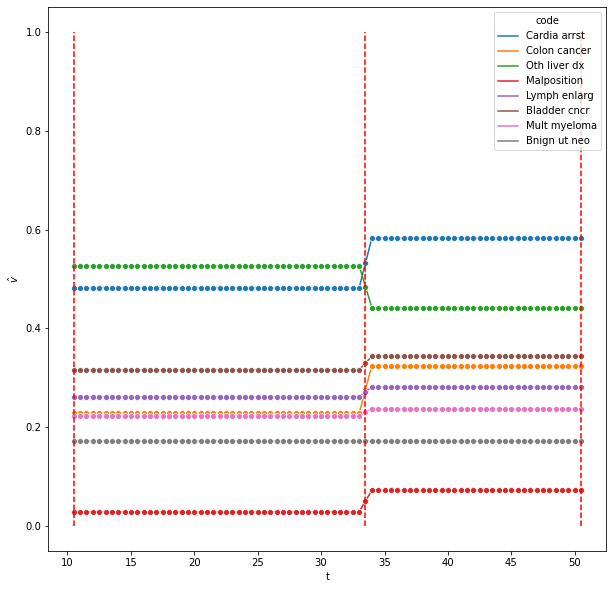

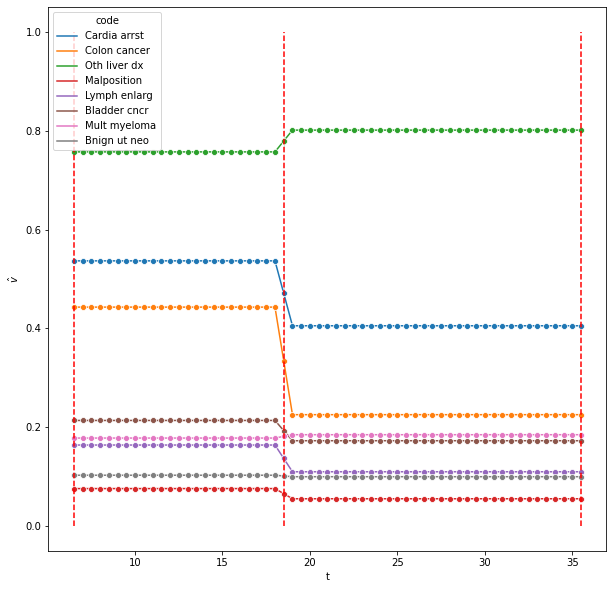

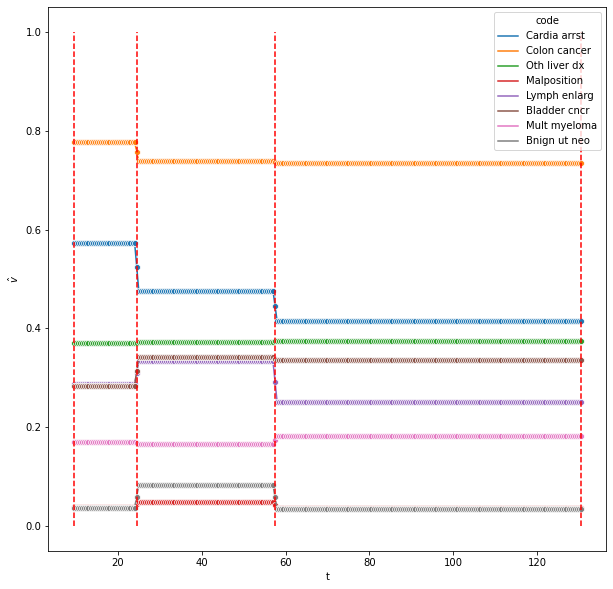

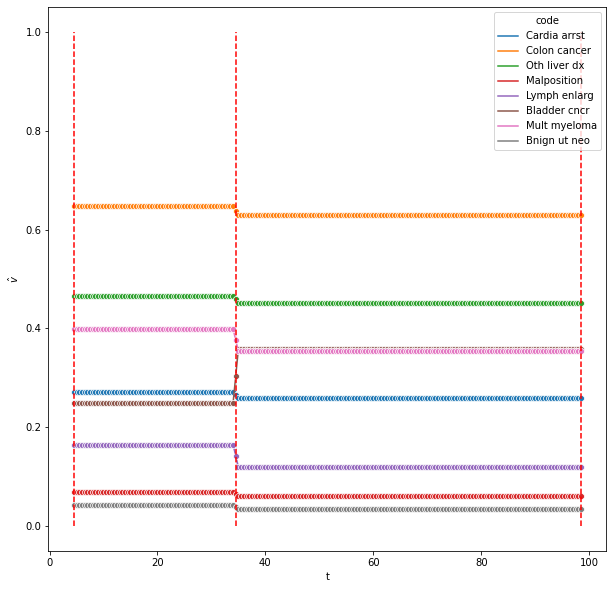

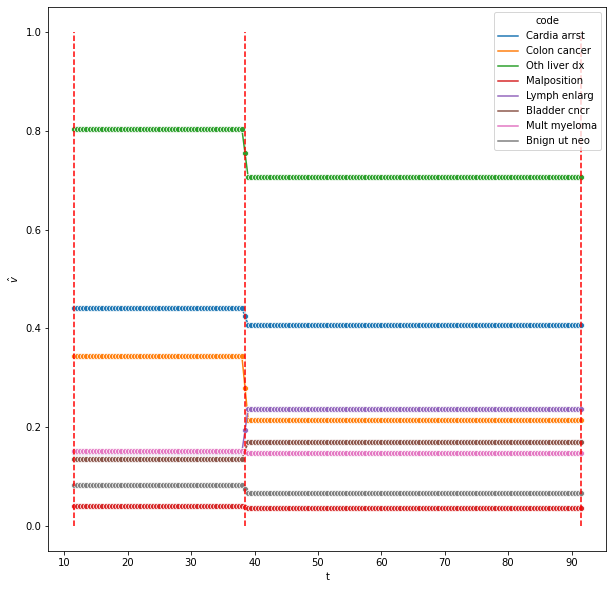

In [137]:
plt.rcParams['figure.figsize']=(10,10)
for i, (df, diag_times) in data.items():
    plt.figure(i)
    sns.lineplot(data=df, x="t", y=r'$\hat{v}$', hue='code', marker='o')
    plt.vlines(diag_times, ymin=0, ymax=1, color="red", linestyle="--")
    #sns.scatterplot(data=data[i], x = 't',  y=r'$\hat{v}$', hue = 'diag_time')

It seems that we cannot catch the smoothness of the trajectory as it evolves very quickly to the saturation value.